In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from scipy import stats

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 8 - Comparing Gaussian means
## 8.1 One-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \mu = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$

In [3]:
# Read data Dr. Smith
Winter = np.array([
    -0.05,0.41,0.17,-0.13,0.00,-0.05,0.00,0.17,0.29,0.04,0.21,0.08,0.37,
            0.17,0.08,-0.04,-0.04,0.04,-0.13,-0.12,0.04,0.21,0.17,0.17,0.17,
            0.33,0.04,0.04,0.04,0.00,0.21,0.13,0.25,-0.05,0.29,0.42,-0.05,0.12,
            0.04,0.25,0.12
])

Summer = np.array([
    0.00,0.38,-0.12,0.12,0.25,0.12,0.13,0.37,0.00,0.50,0.00,0.00,-0.13,
            -0.37,-0.25,-0.12,0.50,0.25,0.13,0.25,0.25,0.38,0.25,0.12,0.00,0.00,
            0.00,0.00,0.25,0.13,-0.25,-0.38,-0.13,-0.25,0.00,0.00,-0.12,0.25,
            0.00,0.50,0.00
])
x = Winter - Summer  # allowed because it is a within-subjects design
x = x / np.std(x)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, delta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


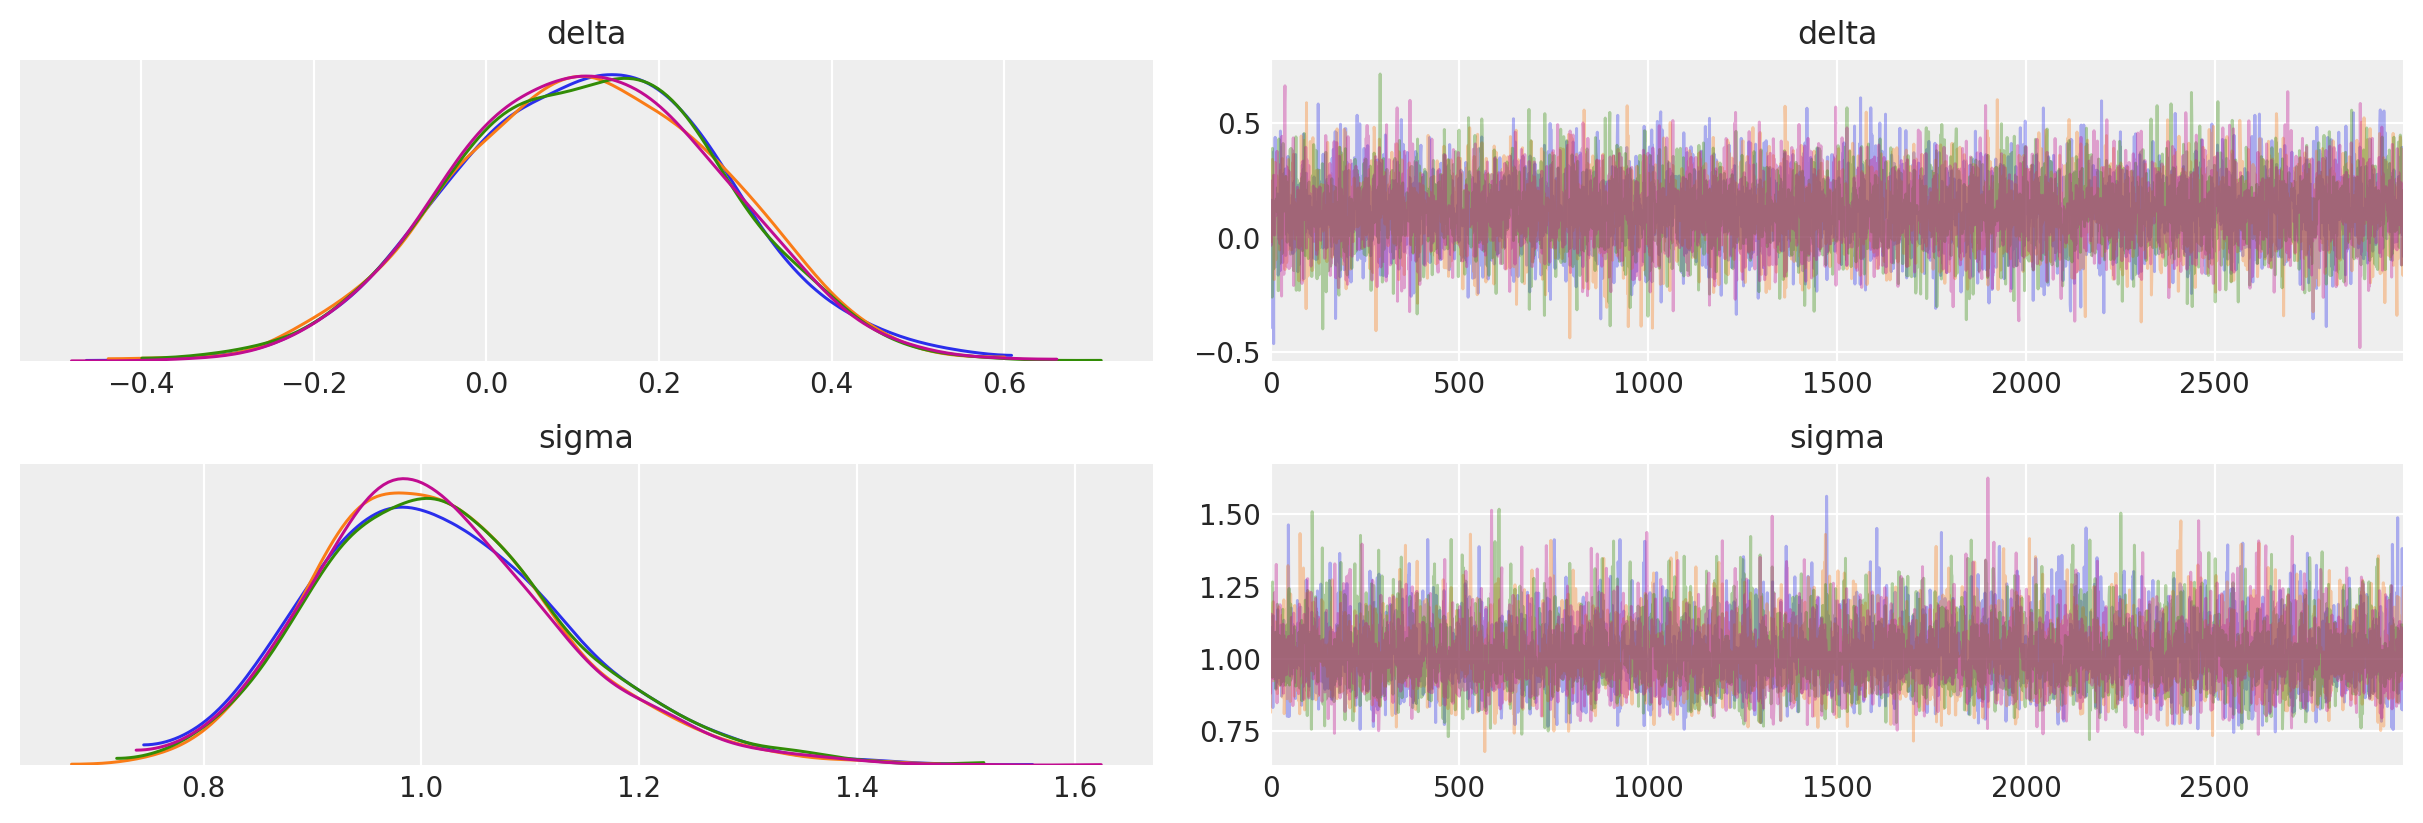

In [4]:
with pm.Model() as model1:
    delta = pm.Cauchy("delta", alpha=0.0, beta=1.0)
    sigma = pm.HalfCauchy("sigma", beta=1.0)

    miu = delta * sigma
    xi = pm.Normal("xi", mu=miu, sd=sigma, observed=x)

    trace1 = pm.sample(3000)

az.plot_trace(trace1);

In [5]:
az.summary(trace1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
delta,0.119,0.154,-0.173,0.394,0.001,0.001,10794.0,7782.0,10803.0,8318.0,1.0
sigma,1.019,0.114,0.806,1.231,0.001,0.001,9874.0,9505.0,10309.0,7746.0,1.0


In [6]:
def display_delta(trace, x):
    # BFs based on density estimation (using kernel smoothing instead of spline)

    tmp = az.summary(trace1, var_names=["delta"])
    # 95% confidence interval:
    x0 = tmp["hpd_3%"]
    x1 = tmp["hpd_97%"]

    t_delt = trace["delta"][:]
    my_pdf = stats.kde.gaussian_kde(t_delt)
    
    plt.plot(
        x, my_pdf(x), "--", lw=2.5, alpha=0.6, label="Posterior"
    )  # distribution function
    plt.plot(x, stats.cauchy.pdf(x), "r-", lw=2.5, alpha=0.6, label="Prior")
    
    posterior = my_pdf(0)  # this gives the pdf at point delta = 0
    prior = stats.cauchy.pdf(0)  # height of order-restricted prior at delta = 0
    BF01 = posterior / prior
    print("the Bayes Factor is %.5f" % (BF01))
    
    plt.plot(
        [0, 0],
        [posterior, prior],
        "k-",
        [0, 0],
        [posterior, prior],
        "ko",
        lw=1.5,
        alpha=1,
    )
    plt.xlabel("Delta")
    plt.ylabel("Density")
    plt.legend(loc="upper left")
    plt.show()

the Bayes Factor is 6.19519


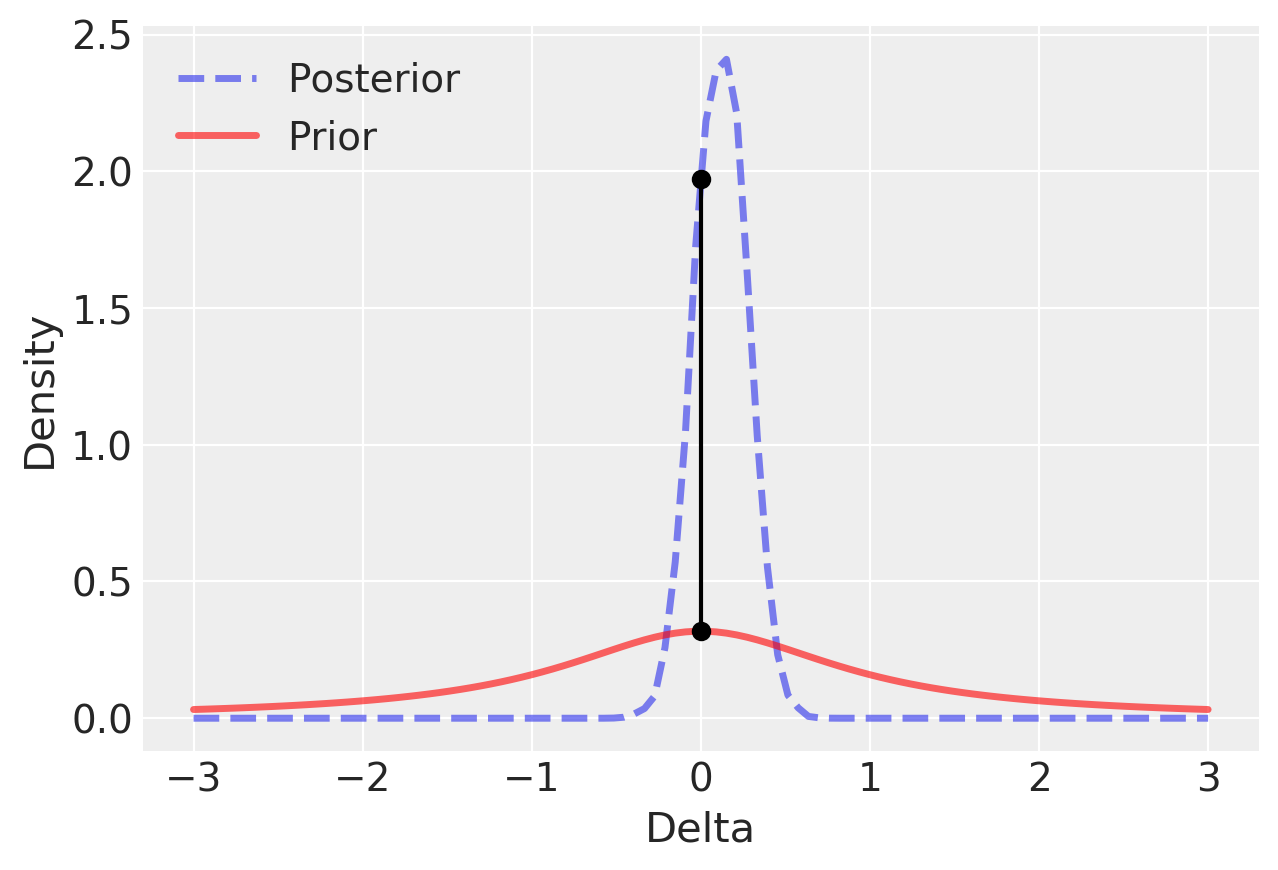

In [7]:
x = np.linspace(-3, 3, 100)
display_delta(trace1, x)

## 8.2 Order-restricted one-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)_{\mathcal I(-∞,0)}$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \mu = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$

In [8]:
# Read data Dr. Smith
Winter = np.array([
    -0.05,0.41,0.17,-0.13,0.00,-0.05,0.00,0.17,0.29,0.04,0.21,0.08,0.37,
            0.17,0.08,-0.04,-0.04,0.04,-0.13,-0.12,0.04,0.21,0.17,0.17,0.17,
            0.33,0.04,0.04,0.04,0.00,0.21,0.13,0.25,-0.05,0.29,0.42,-0.05,0.12,
            0.04,0.25,0.12
])

Summer = np.array([
    0.00,0.38,-0.12,0.12,0.25,0.12,0.13,0.37,0.00,0.50,0.00,0.00,-0.13,
            -0.37,-0.25,-0.12,0.50,0.25,0.13,0.25,0.25,0.38,0.25,0.12,0.00,0.00,
            0.00,0.00,0.25,0.13,-0.25,-0.38,-0.13,-0.25,0.00,0.00,-0.12,0.25,
            0.00,0.50,0.00
])
x = Winter - Summer  # allowed because it is a within-subjects design
x = x / np.std(x) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, delta1]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 3 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


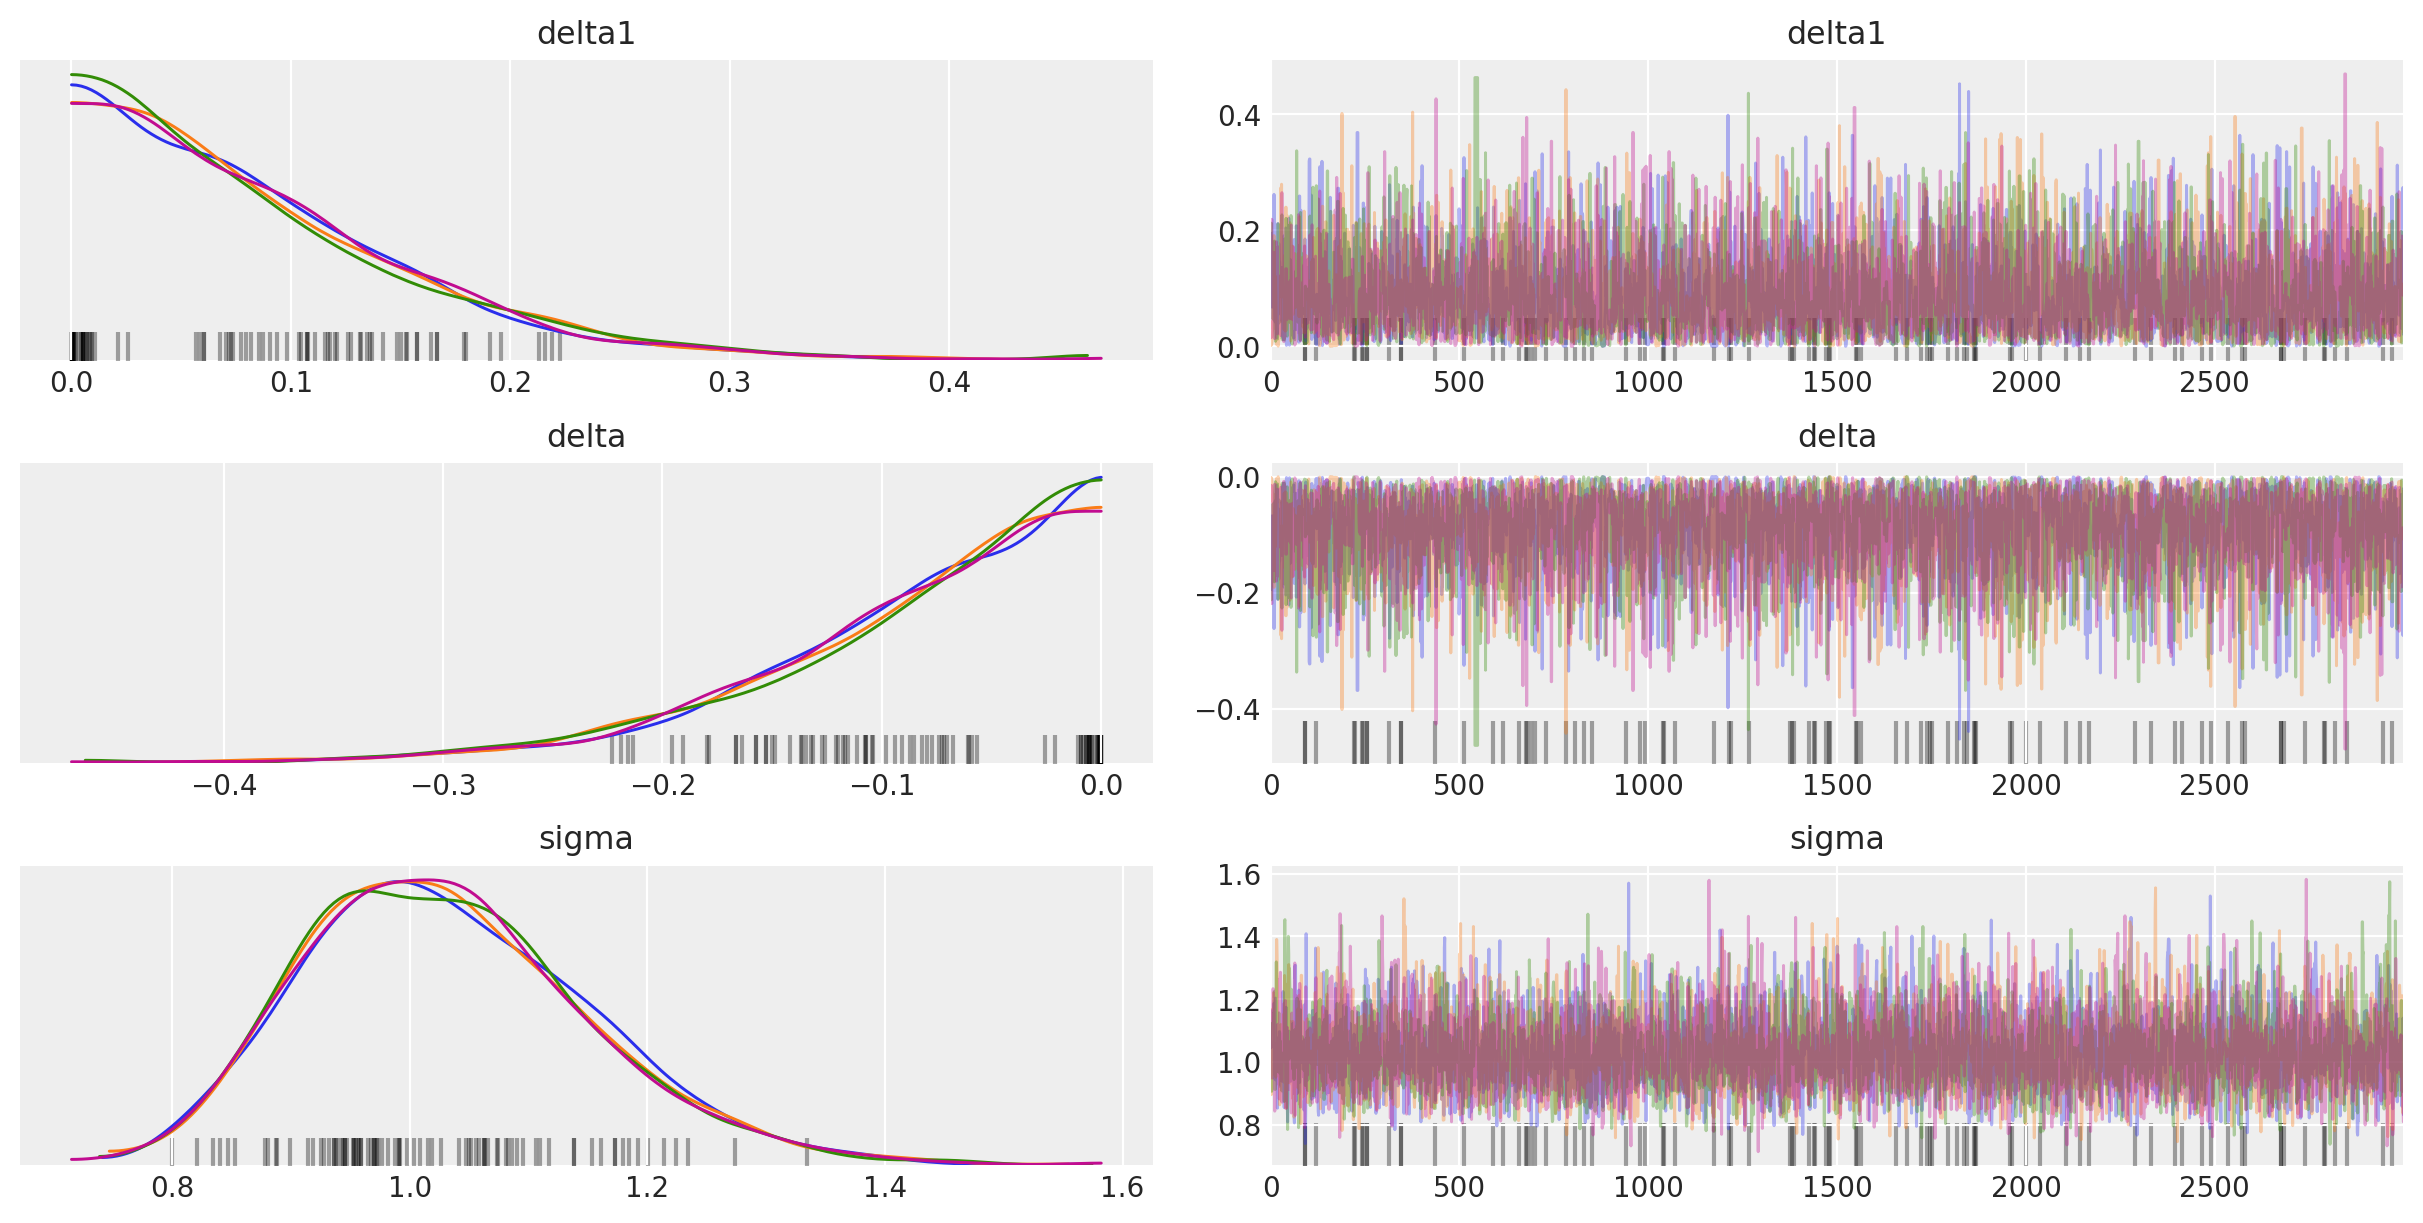

In [9]:
with pm.Model() as model2:
    delta1 = pm.HalfCauchy("delta1", beta=1.0)
    delta = pm.Deterministic("delta", -delta1)
    sigma = pm.HalfCauchy("sigma", beta=1.0)

    miu = delta * sigma
    xi = pm.Normal("xi", mu=miu, sd=sigma, observed=x)

    trace2 = pm.sample(3000, tune=2000)

az.plot_trace(trace2);

the Bayes Factor is 12.80091


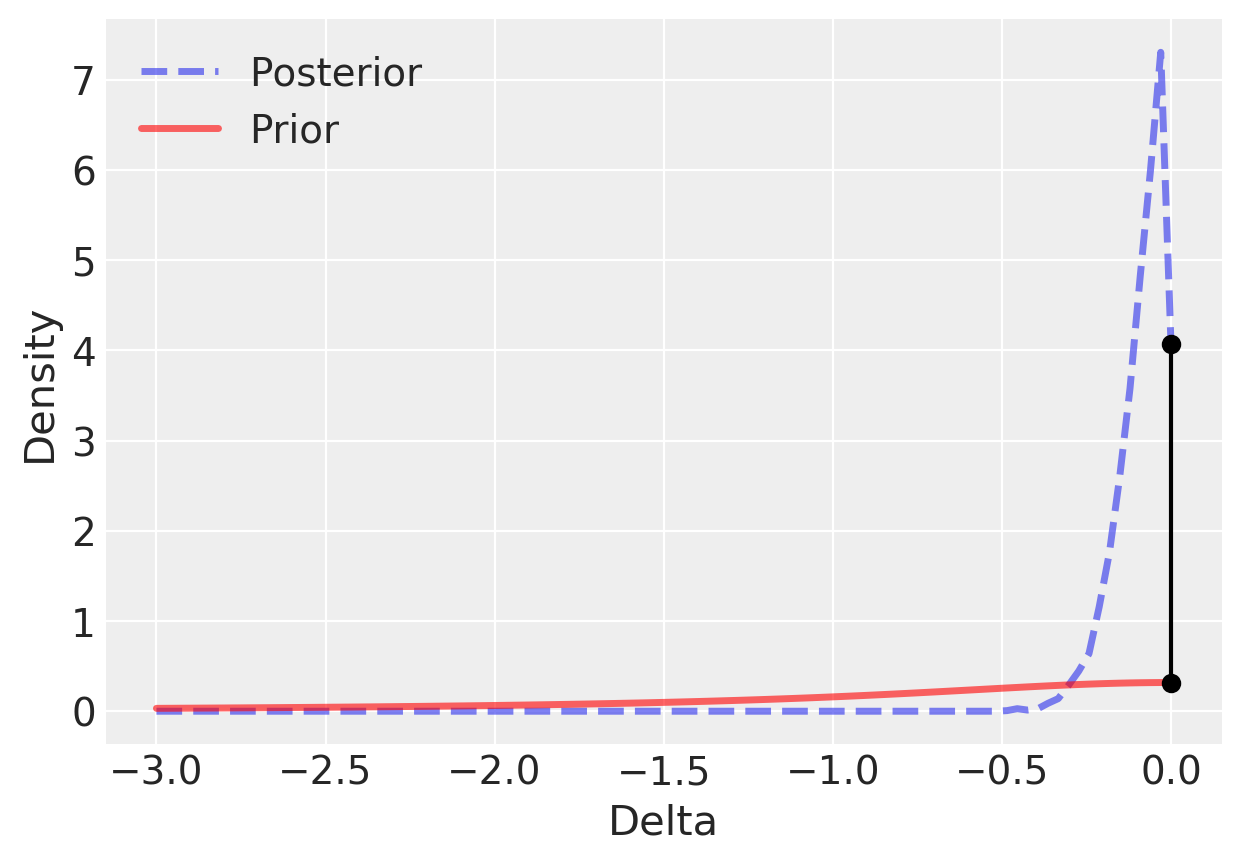

In [10]:
x = np.linspace(-3, 0, 100)
display_delta(trace2, x)

## 8.3 Two-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)$$
$$ \mu \sim \text{Cauchy} (0, 1)$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \alpha = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu+\frac{\alpha}{2},1/\sigma^2)$$
$$ y_{i} \sim \text{Gaussian}(\mu-\frac{\alpha}{2},1/\sigma^2)$$


In [11]:
# Read data
x = np.array(
    [70, 80, 79, 83, 77, 75, 84, 78, 75, 75, 78, 82, 74, 81, 72, 70, 75, 72, 76, 77]
)
y = np.array(
    [56, 80, 63, 62, 67, 71, 68, 76, 79, 67, 76, 74, 67, 70, 62, 65, 72, 72, 69, 71]
)

n1 = len(x)
n2 = len(y)

# Rescale
y = y - np.mean(x)
y = y / np.std(x)
x = (x - np.mean(x)) / np.std(x)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu, delta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


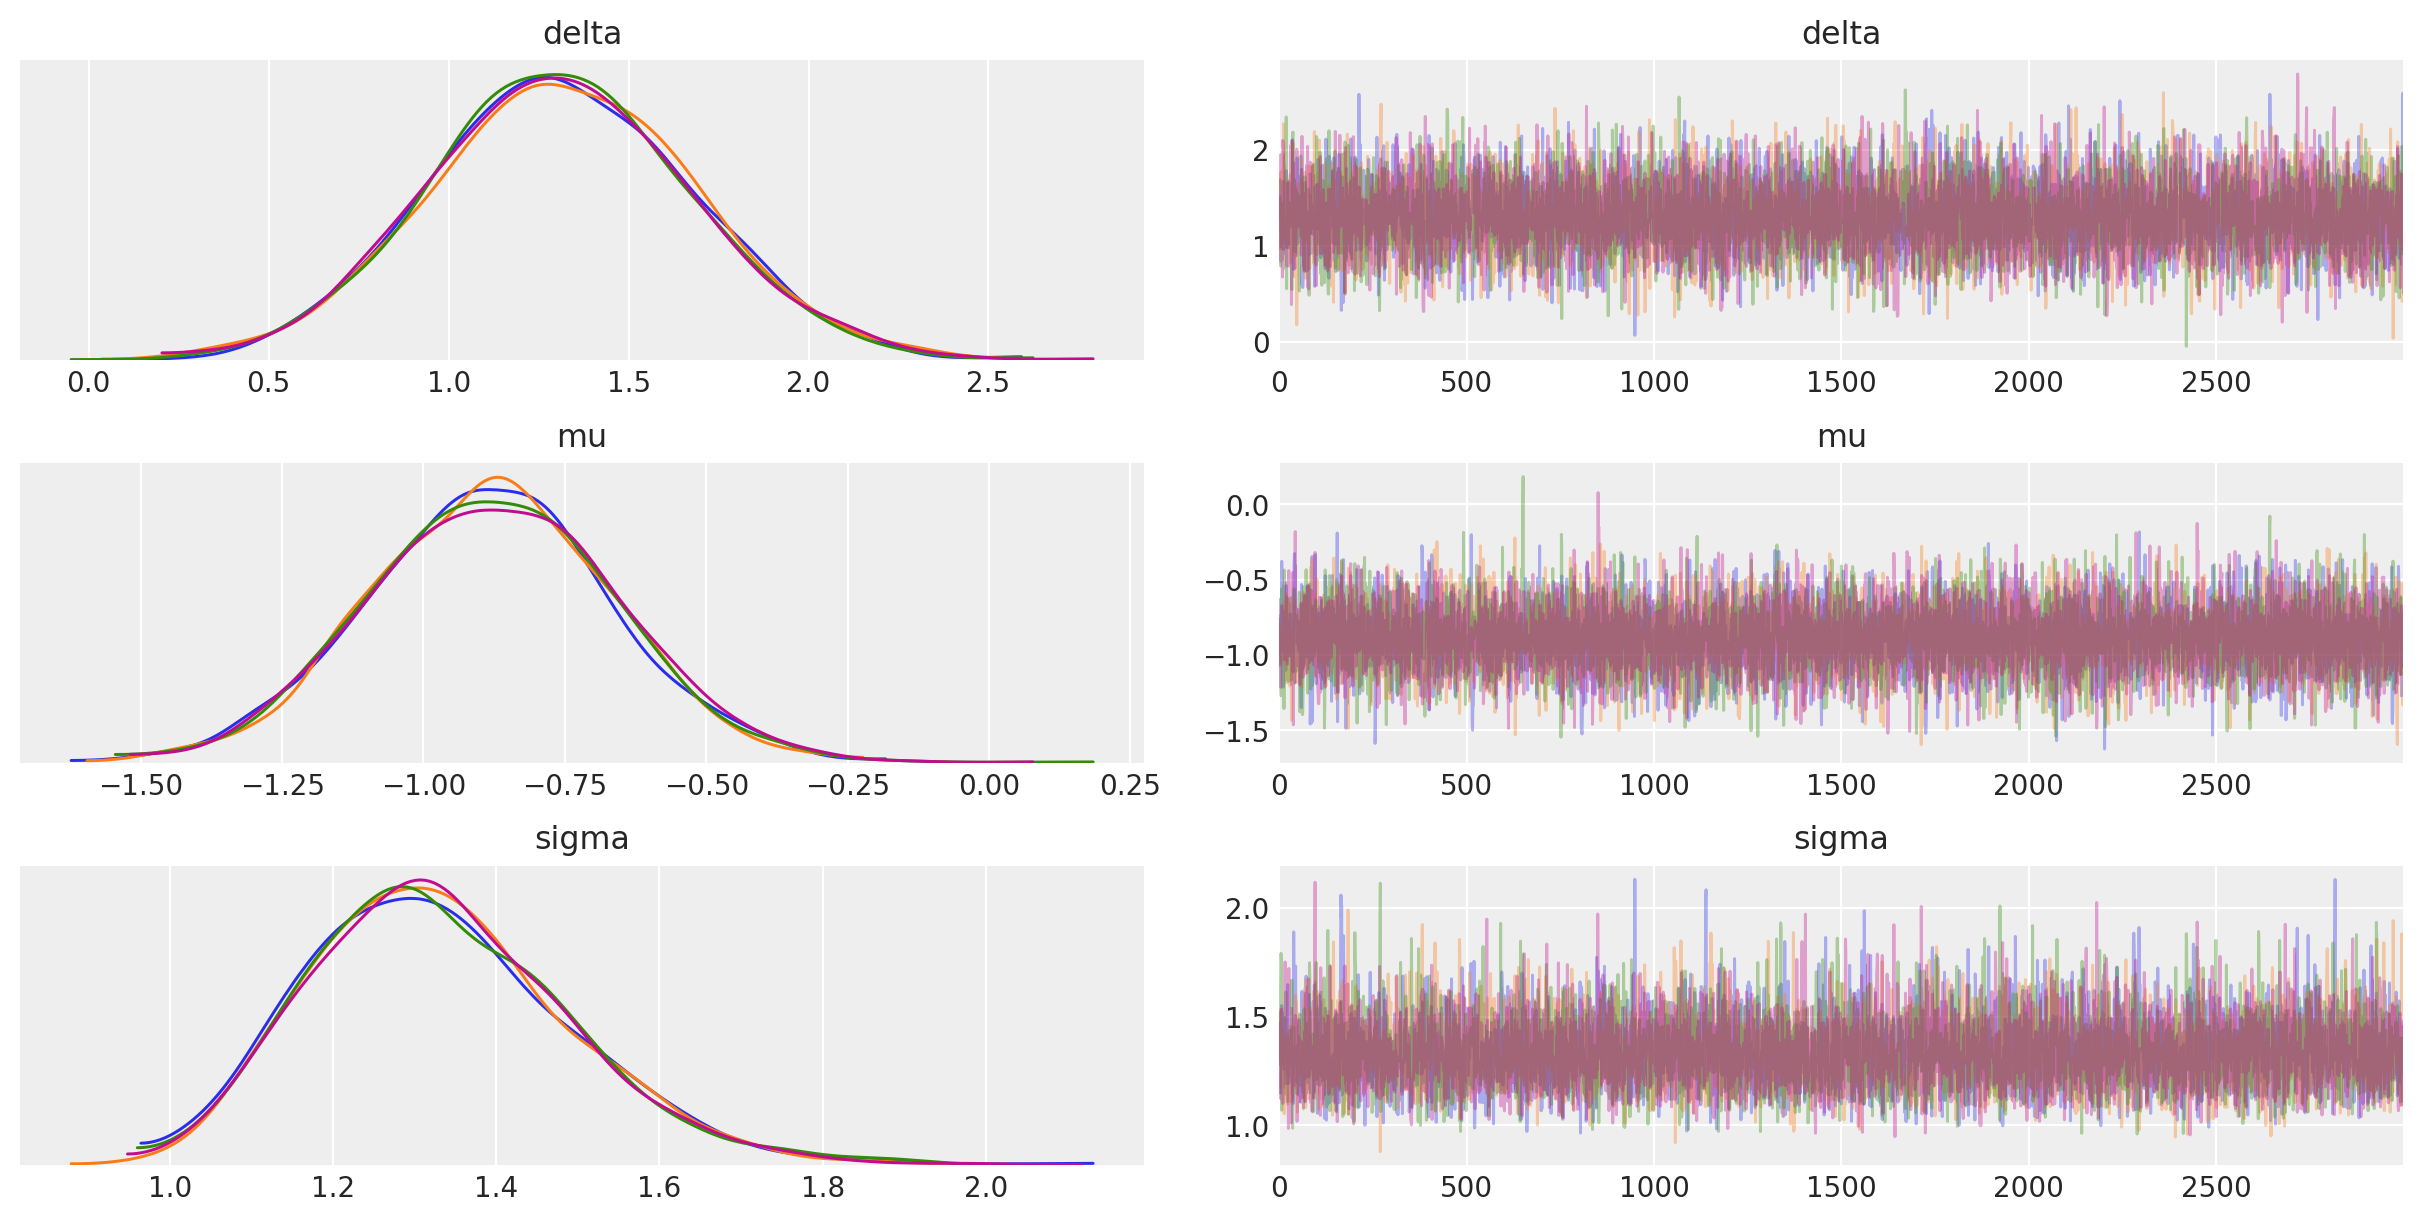

In [12]:
with pm.Model() as model3:
    delta = pm.Cauchy("delta", alpha=0, beta=1)
    mu = pm.Cauchy("mu", alpha=0, beta=1)
    sigma = pm.HalfCauchy("sigma", beta=1)

    alpha = delta * sigma
    xi = pm.Normal("xi", mu=mu + alpha / 2, sd=sigma, observed=x)
    yi = pm.Normal("yi", mu=mu - alpha / 2, sd=sigma, observed=y)

    trace3 = pm.sample(3000)

az.plot_trace(trace3);

the Bayes Factor is 0.00378


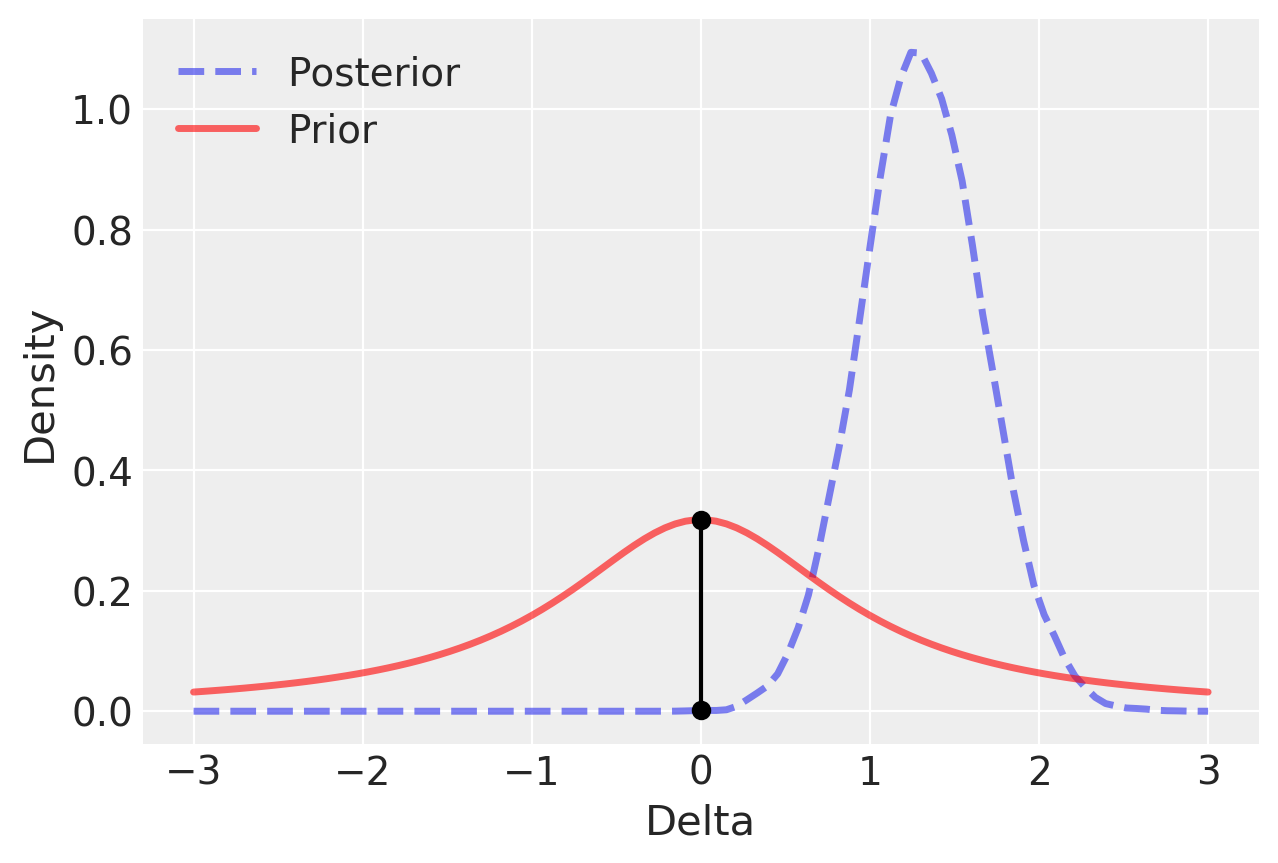

In [13]:
x = np.linspace(-3, 3, 100)
display_delta(trace3, x)

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas 1.0.3
arviz  0.7.0
numpy  1.18.1
pymc3  3.8
last updated: Sat Apr 25 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
